In [22]:
import pygame
import gym_examples
import gymnasium as gym
import numpy as np
import masters
import netCDF4
from numpy import array as ar
from numpy import array
# import pandas as pd
# from pandas import DataFrame as DF
import itertools
from collections import defaultdict
import time

# action is torque which is continuous.
# Since it is continuous, we want to learn the parameters for 
# action = b0 + b1*theta*(theta <= 180) + b2*(360-theta)*(theta > 180) + b3*abs(angular_velocity)^b4*(angular_velocity <=0) - b3*abs(angular_velocity)^b4*(angular_velocity >= 0)
# 
class REINFORCEAgent:
    def __init__(self, batch_size, stdev=1, lr=1e-2):
        self.batch_size = batch_size
        self.num_parameters = 1
        self.lr = lr
        # self.pred = np.array([0, 0.1]) # mean, stdev. stdev hardcoded to 0.1
        self.stdev = stdev # The mean and stdev aren't tuneable parameters. They are the outputs. We use them to get action probabilities.
                           # We want to learn the parameters that convert from obs to our outputs.
                           # stdev hardcoded to 0.1 because i'm lazy and only want to tune a single parameter.
        self.b = np.array([(np.random.rand() - 0.5)/10])# (np.random.rand() - 0.5)/10]) #np.zeros(self.num_parameters) # parameter values. name comes from how linear regression uses b0,b1,... for their coefficients.
        # initialize to be random
        
    def get_action(self, obs):
        mu = self.obs2mu(obs)
        return np.random.normal(mu,self.stdev)

    def obs2mu(self, obs):
        mu = self.b[0] #+ self.b[1]*obs[0]
        return mu

    # Calculate the policy gradient for a single episode. When training you should have multiple batches of episodes.
    def calculate_policy_gradient(self, obs,act,Rtau):
        # obs, and act are supposed to be arrays with size [episode_length][observation_length_or_action_length].
        # Rtau is a number equal to the total reward of that episode.
        gradb0=0.0 # this is the expression for grad-log-prob
        # gradb1=0.0
        # from IPython.core.debugger import Pdb; Pdb().set_trace()
        for i in range(len(obs)): # sum over t
            
            gradb0 += Rtau * ( act[i] - self.b[0] )#- self.b[1]*obs[i][0] )
            # ( (theta >=0) * ( -(act[i] - self.b[0]*theta)/self.stdev * (-self.b[0]/self.stdev) ) + (theta <0) * ( -(act[i] + self.b[0]*theta)/self.stdev * (self.b[0]/self.stdev) ) )
            # gradb1 += Rtau * ( act[i] - self.b[0]*obs[i][0] - self.b[1]*obs[i][0]*obs[i][0] )
        return gradb0#np.array([gradb0, gradb1]) # only 1 parameter so grad is a float. If multiple parameters then grad will be an array.

    def update(self, batch_obs,batch_act,batch_Rtau):
        # obs, and act are supposed to be arrays with size [batch_size][episode_length][observation_length_or_action_length]
        # Rtau and episode_lengths should arrays with size [batch_size].

        batch_grad = 0.0# np.array([0.0, 0.0]) # This is g\hat
        for i in range(self.batch_size): # sum over \scriptD
            batch_grad += self.calculate_policy_gradient(batch_obs[i],batch_act[i],batch_Rtau[i])

        # from IPython.core.debugger import Pdb; Pdb().set_trace()
        self.b[0] += self.lr * (1/self.batch_size) * batch_grad
        # self.b[1] += self.lr * (1/self.batch_size) * batch_grad[1] # lazy. copy paste faster
        
        return batch_grad

In [23]:
def train_one_epoch(agent):
    # make some empty lists for logging.
    batch_obs = []          # for observations
    batch_act = []         # for actions
    batch_Rtau = []      # for R(tau) weighting in policy gradient
    batch_rets = []         # for measuring episode returns
    batch_lens = []         # for measuring episode lengths

    # collect experience by acting in the environment with current policy until the number of episodes equals batch_size.
    for i in range(batch_size):
        obs = env.reset()[0]
        done = False
        ep_obs = []
        ep_act = []
        ep_Rtau = 0
        while not done:
            # save obs
            ep_obs.append(obs)
    
            # act in the environment
            act = agent.get_action(obs)
            obs, rew, terminated, truncated, _ = env.step(np.array([act], dtype=np.float32))

            done = terminated or truncated
            
            ep_act.append(act)
            ep_Rtau += rew
    
            if done:
                # if episode is over, record info about episode
                batch_obs.append(ep_obs)
                batch_act.append(ep_act)
                batch_lens.append(len(ep_obs))
    
                # the weight for each logprob(a|s) is R(tau)
                batch_Rtau.append(ep_Rtau)
                
                break # this increments i because it breaks out of the while.
    
    # take a single policy gradient update step
    # optimizer.zero_grad()
    # batch_loss = compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32),
    #                           act=torch.as_tensor(batch_acts, dtype=torch.int32),
    #                           weights=torch.as_tensor(batch_weights, dtype=torch.float32) # Weights are the R(tau) values
    #                           )
    # batch_loss.backward()
    # optimizer.step()
    policy_gradient = agent.update(batch_obs,batch_act,batch_Rtau)
    
    return policy_gradient, batch_Rtau, batch_lens

In [24]:
from tqdm import tqdm
epochs=100
batch_size=1000
env = gym.make('gym_examples/SimpleRight-v0')
obs=env.reset()[0]

REINFORCE_Agent = REINFORCEAgent(batch_size, stdev=0.5)

# training loop
reward_records = []
minimum_epochs = 50
tolerance = 0.
number_of_batches_that_return_is_averaged_over = 50
average_average_return = [] # average over the last 50 batches. return of a batch is also averaged which is why this is called average average return
patience = 20

bees = []
for i in (range(epochs)):
    if i > minimum_epochs and abs(average_average_return[-1] - max(average_average_return[i-patience:-1])) <= tolerance:
        break
    policy_gradient, batch_Rtau, batch_lens = train_one_epoch(REINFORCE_Agent)
    reward_records.append(np.mean(batch_Rtau)) # first average
    if i < number_of_batches_that_return_is_averaged_over:
        avg_list = reward_records[:i+1]
    else:
        avg_list = reward_records[i-number_of_batches_that_return_is_averaged_over-1:i+1]
    avg_return = np.average(avg_list)
    average_average_return.append(avg_return) # second average
    print('b: %.3f \t epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f  \t avg_return_over_last_%3d_episodes: %.3f'%
            (REINFORCE_Agent.b, i, policy_gradient, np.mean(batch_Rtau), np.mean(batch_lens), number_of_batches_that_return_is_averaged_over, avg_return))
# some of the things being printed are useless or wrong i don't care i copy/pasted from the spinning up example

/tmp/ipykernel_279848/1970034944.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('b: %.3f \t epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f  \t avg_return_over_last_%3d_episodes: %.3f'%


b: 0.465 	 epoch:   0 	 loss: 43901.954 	 return: -253.773 	 ep_len: 51.000  	 avg_return_over_last_ 50_episodes: -253.773
b: 0.729 	 epoch:   1 	 loss: 26349.480 	 return: -231.323 	 ep_len: 51.000  	 avg_return_over_last_ 50_episodes: -242.548
b: 1.095 	 epoch:   2 	 loss: 36642.617 	 return: -217.935 	 ep_len: 51.000  	 avg_return_over_last_ 50_episodes: -234.344
b: 1.297 	 epoch:   3 	 loss: 20205.583 	 return: -199.173 	 ep_len: 51.000  	 avg_return_over_last_ 50_episodes: -225.551
b: 1.436 	 epoch:   4 	 loss: 13905.019 	 return: -188.837 	 ep_len: 51.000  	 avg_return_over_last_ 50_episodes: -218.208
b: 1.553 	 epoch:   5 	 loss: 11638.435 	 return: -181.735 	 ep_len: 51.000  	 avg_return_over_last_ 50_episodes: -212.129
b: 1.268 	 epoch:   6 	 loss: -28467.410 	 return: -175.572 	 ep_len: 51.000  	 avg_return_over_last_ 50_episodes: -206.907
b: 1.596 	 epoch:   7 	 loss: 32805.873 	 return: -190.429 	 ep_len: 51.000  	 avg_return_over_last_ 50_episodes: -204.847
b: 1.871 	 epoc

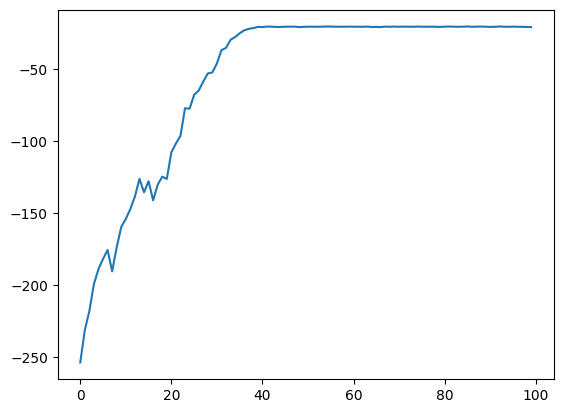

In [26]:
import matplotlib.pyplot as plt
plt.plot(reward_records)
# plt.plot(average_average_return)